# Error metrics for classification models

**Lesson objectives**:
* Understand why accuracy isn't always the best error metric for classification
* Understand the confusion matrix
* Learn the difference between precision and recall 
* Understand what changing the probability cutoff for logistic regression does to precision and recall and how one might use this in model development
* Learn how to balance precision and recall using the F1 score
* Understand the ROC curve: how to interpret it and how to use it for model tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

## Classification on the dataset with two classifiers: kNN and logistic

In [15]:
X = pd.read_pickle('/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/df_X.pickle')
y = pd.read_pickle('/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/df_y.pickle')

In [16]:
# As usual, create our train/test split
# This will become particularly important as we calculate our error metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state = 42)

In [17]:
#when using scaled solution, takes a long time 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [18]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test_scaled, y_test)))

The score for kNN is
Training:  99.74%
Test set:  86.12%


In [19]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

The score for logistic regression is
Training:  72.52%
Test set:  72.44%


Unlike kNN, the logistic regression model has a probabiltiy method built into it. Let's look at the predicted probabilities for the first few observations.

In [20]:
# Let's do a prediction of the first 5 observations from logistic

logit.predict_proba(X_test[:5,])

TypeError: '(slice(None, 5, None),)' is an invalid key

Let's look at the type of errors that these two classifiers made:

In [21]:
from sklearn.metrics import confusion_matrix

print("kNN confusion matrix: \n\n", confusion_matrix(y_test, knn.predict(X_test)))

kNN confusion matrix: 

 [[    0 15558]
 [   27  5802]]


i.e. the kNN confused two samples of species 1 as species 2, and one species 2 as a species 1, but managed to get all of the species 0 irises right. 

Note that `confusion[row_number][col_number]` tells us how many of the labels that were actually `row_number` were predicted to be `col_number` by our classifier. We can see that by predicting class 2 for everything (this is not data science, it's just for demonstration!).

In [22]:
# What happens when we just predict class 2 for everything? 
print("Confusion matrix for silly model where we predict all 2's: \n\n", \
      confusion_matrix(y_val, [2]*len(y_val)))

Confusion matrix for silly model where we predict all 2's: 

 [[    0     0 15645]
 [    0     0  5742]
 [    0     0     0]]


We can make this a little prettier by passing the confusion matrix to `sns.heatmap`:

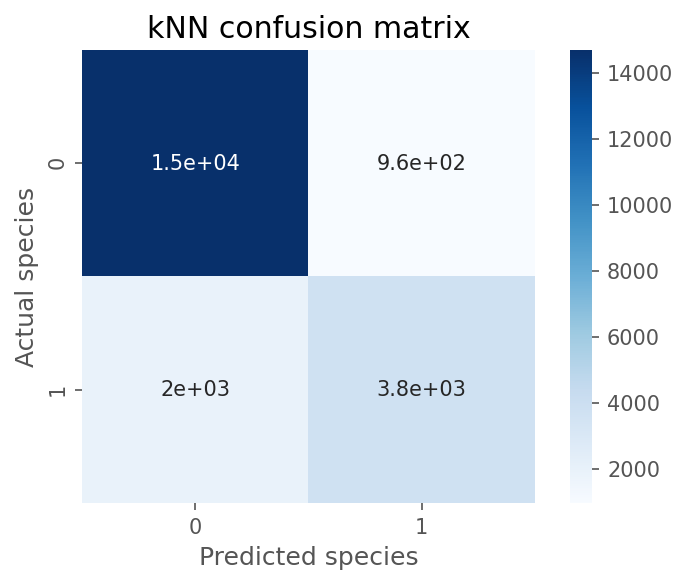

In [23]:
# Print confusion matrix for kNN
knn_confusion = confusion_matrix(y_val, knn.predict(X_val_scaled))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
        #    xticklabels=X['target_names'],
        #    yticklabels=y['target_names'])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('kNN confusion matrix');

In [24]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(label_test, logit.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=iris_dataset['target_names'],
           yticklabels=iris_dataset['target_names'])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Logistic regression confusion matrix');

plt.savefig("confusion_matrix_logit_iris")

NameError: name 'label_test' is not defined

### Why accuracy sometimes doesn't make sense: credit card data example

We are going to look at an example of credit card data, where the positive class is "transaction is fraudulant" and the negative class is "transaction is not fraudulant".

That is, a false positive is a transaction we flag as fraudulant that is actually legitimite, whereas a false negative is a transaction we claim is legitimate that turns out to be fraudulant.

In [12]:
# Let's read in some credit card data!
df = pd.read_csv('https://s3.amazonaws.com/gamma-datasets/P3/creditcard.csv.gz')

---
**STUDENT EXERCISE:**

(1) What's the distribution of fraud to non-fraud cases? 

(2) Now build a confusion matrix where you predict everything as not fraud! Is this helpful? 

---

In [25]:
# Let's make a slightly better model
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-1], df.iloc[:, -1])
lm = LogisticRegression(C = 100)
lm.fit(X_train, y_train)
print("Logistic score: {:6.4f}".format(lm.score(X_train,y_train)))

Logistic score: 0.9992


In [26]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

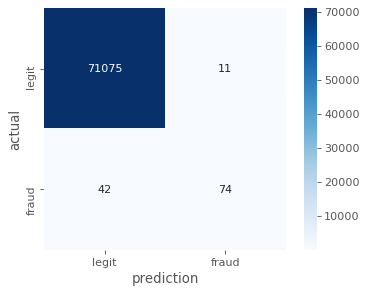

In [27]:
make_confusion_matrix(lm)

In [28]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

**CHECK FOR UNDERSTANDING:**

What happens if we change our threshold to .06? What does this mean? How would our confusion matrix look?


---

## New metrics: precision and recall

We can introduce two new metrics:
- **Precision:** The fraction of postive predictions you made that were correct. 
  High precision means that if your model predicted a positive case, you believe it with high confidence. It doesn't tell us how many postive cases we missed (i.e. it doesn't tell us how sure we are about the cases we predicted were negative).
- **Recall**: The fraction of positive cases you predicted correctly.
  High recall means that you are confident that you didn't miss any positive cases. 
  
The easiest way to get high precision is to call a point positive only when you are very sure. The easiest way to get 100% recall is to predict all points to be positive, as you are guaranteed to label 100% of all positive cases. You should not optimize for either recall or precision -- you need to think about how to balance them against one another.

In formula:
$$ \text{Precision} = \frac{\text{(True positives)}}{\text{Predicted positives}} = \frac{\text{True positives}}{\text{True positives} + \text{False postitives}}$$
and
$$ \text{Recall} = \frac{\text{True positives}}{\text{Actual positives}} = \frac{\text{True positives}}{\text{True positives} + \text{False negatives}}$$

### Example calcuation: fraud when threshold = 0.5 

|_                            | predicted negative (legit) | predicted positive (fraud) | Total |
|-----------------------------| -------------------------- | -------------------------- | ----- |
| **actual negative (legit)** | 71058                      | 11                         | 71069 |
| **actual positive (fraud)** | 47                         | 86                         | 133   |
| **Total**                   | 71105                      | 97                         | 71202 |


For precision:
$$\text{Precision} = \frac{TP}{\text{predicted positive}} = \frac{86}{86 + 11} = 0.887$$
i.e. this 88.7% of the tests positive predictions are correct.

For recall:
$$\text{Recall} = \frac{TP}{\text{actual positives}} = \frac{86}{86+47} = 0.647$$
i.e. the model can only get (or 'remember'/'recall') 64.7% of fraudulent transactions.


### Example calculation: fraud when threshold = 0.06

|-                            | predicted negative (legit) | predicted positive (fraud) | Total |
|-----------------------------| -------------------------- | -------------------------- | ----- |
| **actual negative (legit)** | 71039                      | 30                         | 71069 |
| **actual positive (fraud)** | 23                         | 110                        | 133   |
| **Total**                   | 71062                      | 140                        | 71202 |

Calculating precision and recall:
* Precision = 110 / 140 = 78.5%
* Recall = 110 / 133 = 82.7%
i.e. by lowering the probability threshold before we label a transaction fraud, we caught more fraud (high recall), but we also investigated more innocent transactions (lower precision).

## Big takeaways:

* Using the **same** logistic regression model, we can change the threshold to bias toward more precision (making positives from test more relevant) or recall (increasing the fraction of postives found).
* Precision goes down as you decrease the threshold, while recall goes up. This is called the _precision-recall tradeoff_.
* Which is worse, low recall or low precision? Depends on the cost of making the different types of error.
* We just need the final predictions of the model to calculate precision and recall. We can get sklearn.metrics to calculate them for us

In [25]:
# using the default threshold of 0.5, which is what vanilla predict does
lm = LogisticRegression(C = 100)
lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.4774,   Recall: 0.1194


In [26]:
# using the new threshold of 0.06
y_predict = (lm.predict_proba(X_test)[:,1] > 0.06)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Threshold of 0.06:
Precision: 0.2723,   Recall: 0.9967


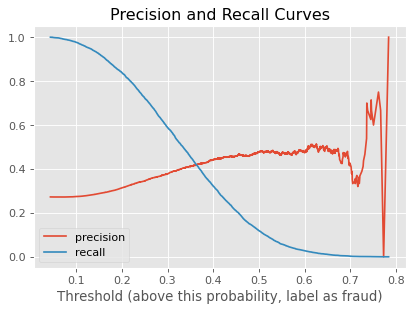

In [27]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

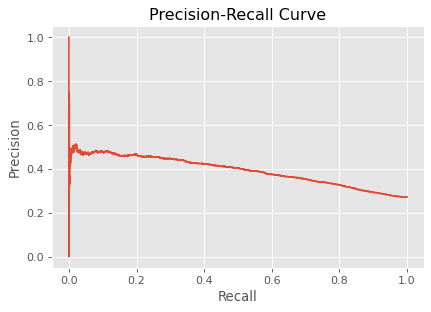

In [28]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

### F1 score: balancing precision vs. recall

A heuristic for finding a good balance is to use $F_1$ score: 

$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

The goal here is to find a balance between a good recall score and a good precision score. We can calculate it manually.

For the default threshold we have

precision = 0.8810, recall = 0.6218

so

$$F_1 = 2\frac{(0.8810)(0.6218)}{0.8810 + 0.6218} = 0.7290$$

---
**STUDENT EXERCISE:**

Use `f1_score` from sklearn to check our calculation above. Look at the F1 score for (1) default threshold and (2) threshold of .06

---

### Generalizing the F1 score

As the name suggests, there is actually a whole family of $F_1$ scores. We have in general:

$$F_{\beta} = \frac{\text{precision} \times \text{recall}}{\text{weighted average of precision and recall}}$$

where the weighted average is given by

$$\text{weighted average} = \frac{\beta^2 \times \text{precision} + 1 \times \text{recall}}{\beta^2 + 1}$$

The rough interpretation is that $F_{\beta}$ attaches $\beta$ times more importance to recall than precision. 

## The ROC curve

We've already seen that we don't have to accept a 50% threshold cutoff. As we've seen, we can plot our models with different thresholds on the same chart and get a ROC curve. This curve plots the *true positive rate* on the y axis, and the *false positive rate* on the x axis. 

In [29]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1])

ROC AUC score =  0.6469631365846759


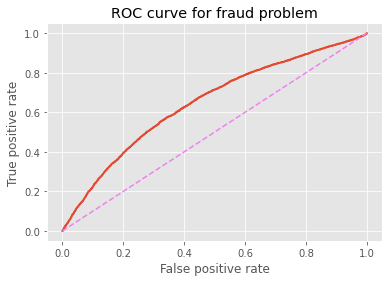

In [30]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, lm.predict_proba(X_test)[:,1]))

The intepretation of the _Area Under the Curve_ (AUC) is the probability that a randomly chosen positive example (in this case, fraud) has a higher score than the randomly chosen negative example (in this case, legitimate transactions).

We see here all the possible TPRs and FNRs that we could have. It is a nice metric because looking at the behavior of our model, we can choose later what we want the threshold to be.


**Question 1: What would a "perfect classifier" look like on this diagram?**

**Question 2: What is the significance of the diagonal line?**

**Question 3: Is it possible to get a classifier that dips below the dotted line?**

**Question 4: Do we have to worry about the class imbalance when using a ROC curve?**

**Question 5: Can we read the threshold off the ROC curve above?**

## Log Loss Cross-Entropy

_A more intensive metric for measuring the performance of your models._ So far, everything we've discussed uses "hard-predictions" to determine how well the model is doing. You apply some threshold and decided, "yes, I believe this is class XYZ" before checking to see if it's actually XYZ. 

That's an okay method, but it doesn't really give us a sense of how close the model was to being wrong. E.g., if we have a threshold of `0.5` and a record that's actually class 1, precision, recall, accuracy, etc. all give equal credit to a prediction that got the class correct, whether it was with `p = 0.51` or `p=0.99`. The second is much higher confidence though! 

Similarly, they give equal penalty to `p = 0.49` and `p=0.01`, though we were much more confident (in the wrong direction) in the second case. Guesses around `0.5` shouldn't be penalized as much, because our model is already admitting "hey, I don't really know what this observation is." 

Enter log-loss. For the binary case, we can define log-loss:

$$ LLCE = - \sum_{i=1}^{N} y \cdot log(p_{y}) + (1-y) \cdot log((1-p_{y}))$$

What does this do? It says, "If the class is actually 1, did you predict close to p=1? If not, that's a big penalty. Though, we'll penalize you way more if you predicted close to p=0. If the class is actually 0, did you predict close to p=0? If not, that's another big penalty."

The main take-aways here are:

>- Log-loss allows us to measure not just "did our model get XYZ right?" but "how confident was it in when predicting?"
>
>- A lower log-loss is better

The cost function typically used for Gradient Descent on classification is log-loss-cross-entropy!

In [33]:
from sklearn.metrics import log_loss

print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, logreg.predict_proba(X_val_scaled))))

NameError: name 'logreg' is not defined

In [ ]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier()
dc.fit(X_train, y_train)
print("Log-loss on dummy classifier: {:6.4f}".format(log_loss(y_test, dc.predict_proba(X_test))))

The logistic significantly outperforms the dummy here (since it's much smarter about its "how confident am I") despite not really outperforming the dummy model much in accuracy.

In [ ]:
print("Logistic accuracy: {:6.4f}".format(lm.score(X_test, y_test)))
print("Dummy accuracy: {:6.4f}".format(dc.score(X_test, y_test)))